In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# First use inspector to look at data and detemine table anmes
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [6]:
columns = inspector.get_columns('measurement')
for column in columns:
    print(column['name'], column['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [7]:
columns = inspector.get_columns('station')
for column in columns:
    print(column['name'], column['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [8]:
# reflect an existing database into a new model

Base = automap_base()

# reflect the tables

Base.prepare(engine, reflect = True)

In [9]:
# View all of the classes that automap found

Base.classes.keys()

['measurement', 'station']

In [10]:
# Save references to each table

Measurement = Base.classes.measurement
Station = Base.classes.station

In [11]:
# Create our session (link) from Python to the DB

session = Session(engine)

# Exploratory Precipitation Analysis

In [12]:
# Find the most recent date in the data set.

session.query(Measurement.date).order_by(Measurement.date.desc()).first()

('2017-08-23')

In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.

# Perform a query to retrieve the data and precipitation scores

year_query = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= '2016-08-23')

# Save the query results as a Pandas DataFrame and set the index to the date column

year_df = pd.read_sql(year_query.statement, engine)

year_df.set_index('date', inplace = True)

# Sort the dataframe by date

year_df.sort_values(by = "date", inplace = True)

In [14]:
year_df_dsum = year_df.groupby("date").sum()
year_df_dsum = year_df_dsum["prcp"].round(2).to_frame()
display(year_df_dsum)

,prcp
date,
2016-08-23,2.71
2016-08-24,9.33
2016-08-25,0.54
2016-08-26,0.10
2016-08-27,0.32
...,...
2017-08-19,0.09
2017-08-20,0.01
2017-08-21,0.58


In [15]:
# Create vector of positions for x-axis labels

x_even = list(np.linspace(0, 365, num = 12))

import datetime as dt

# Make date vector for axis labels

dates = []

for i in range(8, 13):
    dates.append(str(dt.date(2016, i, 23)))

for j in range(1, 9):
    dates.append(str(dt.date(2017, j, 23)))

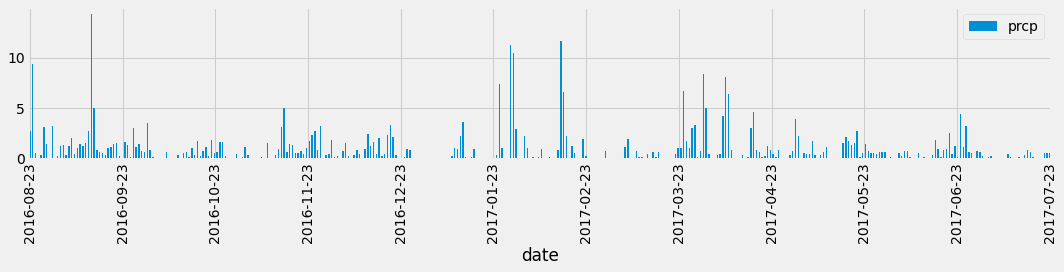

In [16]:
# Use Pandas Plotting with Matplotlib to plot the data`

year_df_dsum.plot(kind = "bar", figsize = (15, 4))
plt.xticks(ticks= x_even, labels = dates)
plt.tight_layout()
plt.show()

In [17]:
# Use Pandas to calcualte the summary statistics for the precipitation data

year_df_dsum.describe()

,prcp
count,366.000000
mean,0.978907
std,1.776349
min,0.000000
25%,0.052500
50%,0.405000
75%,1.087500
max,14.280000


# Exploratory Station Analysis

In [18]:
# Design a query to calculate the total number stations in the dataset

session.query(Station.station).count()

9

In [19]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.

station_activity = session.query(Measurement.station, func.count(Measurement.station))\
                          .group_by(Measurement.station)\
                          .order_by(func.count(Measurement.station).desc())\
                          .all()
station_activity

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [20]:
# Using the most active station id, calculate the lowest, highest, and average temperature.

station_id = station_activity[0][0]

temp_min = session.query(func.min(Measurement.tobs)).filter(Measurement.station == station_id).first()[0]
temp_max = session.query(func.max(Measurement.tobs)).filter(Measurement.station == station_id).first()[0]
temp_avg = session.query(func.avg(Measurement.tobs)).filter(Measurement.station == station_id).first()[0]

print(f"The minimum temperature at station {station_id} was {temp_min} degrees.")
print(f"The maximum temperature at station {station_id} was {temp_max} degrees.")
print(f"The average temperature at station {station_id} was {round(temp_avg, 1)} degrees.")

The minimum temperature at station USC00519281 was 54.0 degrees.
The maximum temperature at station USC00519281 was 85.0 degrees.
The average temperature at station USC00519281 was 71.7 degrees.


In [21]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

temps_last_year = session.query(Measurement.tobs).filter(Measurement.station == station_id)\
                                                 .filter(Measurement.date >= '2016-08-23').all()

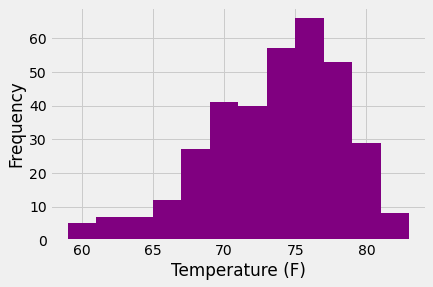

In [22]:
temps_list = [item for t in temps_last_year for item in t]

plt.hist(temps_list, bins = 12, color = "purple")
plt.xlabel("Temperature (F)")
plt.ylabel("Frequency")
plt.show()

# Close session

In [24]:
# Close Session
session.close()